# Model

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import requests
import json

In [2]:
german = pd.read_csv('german_credit.csv')

In [3]:
german_prep = german

target = german_prep['default']
temp = german_prep.drop(['default'], axis = 1)

In [4]:
german_model = pd.concat([temp, target], axis = 1)

In [5]:
X = german_model.iloc[:,0:len(german_model.columns)-1]
y = german_model.iloc[:,len(german_model.columns)-1]

In [6]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # test size 20% from train test

In [7]:
X_train_ori = X_train
X_test_ori = X_test

In [8]:
X_train_ori

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,other_debtors,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
687,0 <= ... < 200 DM,36,delay in paying off in the past,car (new),2862,100 <= ... < 500 DM,.. >= 7 years,4,male : single,none,3,unknown / no property,30,none,for free,1,skilled employee / official,1,none,yes
500,< 0 DM,24,existing credits paid back duly till now,car (new),3123,... < 100 DM,... < 1 year,4,female : divorced/separated/married,none,1,if not A121 : building society savings agreeme...,27,none,own,1,skilled employee / official,1,none,yes
332,0 <= ... < 200 DM,60,existing credits paid back duly till now,car (new),7408,100 <= ... < 500 DM,... < 1 year,4,female : divorced/separated/married,none,2,if not A121 : building society savings agreeme...,24,none,own,1,management/ self-employed/ highly qualified em...,1,none,yes
979,0 <= ... < 200 DM,15,all credits at this bank paid back duly,car (new),1264,100 <= ... < 500 DM,1 <= ... < 4 years,2,male : married/widowed,none,2,if not A121 : building society savings agreeme...,25,none,rent,1,skilled employee / official,1,none,yes
817,no checking account,6,critical account/ other credits existing (not ...,domestic appliances,1554,... < 100 DM,4 <= ... < 7 years,1,female : divorced/separated/married,none,2,"if not A121/A122 : car or other, not in attrib...",24,none,rent,2,skilled employee / official,1,"yes, registered under the customers name",yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,< 0 DM,12,no credits taken/ all credits paid back duly,car (new),1082,... < 100 DM,1 <= ... < 4 years,4,male : single,none,4,"if not A121/A122 : car or other, not in attrib...",48,bank,own,2,skilled employee / official,1,none,yes
192,0 <= ... < 200 DM,27,existing credits paid back duly till now,business,3915,... < 100 DM,1 <= ... < 4 years,4,male : single,none,2,"if not A121/A122 : car or other, not in attrib...",36,none,own,1,skilled employee / official,2,"yes, registered under the customers name",yes
629,no checking account,9,existing credits paid back duly till now,(vacation - does not exist?),3832,unknown/ no savings account,.. >= 7 years,1,male : single,none,4,real estate,64,none,own,1,unskilled - resident,1,none,yes
559,0 <= ... < 200 DM,18,critical account/ other credits existing (not ...,radio/television,1928,... < 100 DM,... < 1 year,2,male : single,none,2,real estate,31,none,own,2,unskilled - resident,1,none,yes


In [9]:
# Categorical boolean mask
categorical_feature_mask = german_model.dtypes==object
numerical_feature_mask = german_model.dtypes!=object

# filter categorical columns using mask and turn it into a list
categorical_cols = german_model.columns[categorical_feature_mask]
numerical_cols = german_model.columns[numerical_feature_mask]

In [10]:
from sklearn.preprocessing import LabelEncoder
temp = {}
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(X_train[col])
    temp[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [11]:
temp

{'account_check_status': {'0 <= ... < 200 DM': 0,
  '< 0 DM': 1,
  '>= 200 DM / salary assignments for at least 1 year': 2,
  'no checking account': 3},
 'credit_history': {'all credits at this bank paid back duly': 0,
  'critical account/ other credits existing (not at this bank)': 1,
  'delay in paying off in the past': 2,
  'existing credits paid back duly till now': 3,
  'no credits taken/ all credits paid back duly': 4},
 'purpose': {'(vacation - does not exist?)': 0,
  'business': 1,
  'car (new)': 2,
  'car (used)': 3,
  'domestic appliances': 4,
  'education': 5,
  'furniture/equipment': 6,
  'radio/television': 7,
  'repairs': 8,
  'retraining': 9},
 'savings': {'.. >= 1000 DM ': 0,
  '... < 100 DM': 1,
  '100 <= ... < 500 DM': 2,
  '500 <= ... < 1000 DM ': 3,
  'unknown/ no savings account': 4},
 'present_emp_since': {'.. >= 7 years': 0,
  '... < 1 year ': 1,
  '1 <= ... < 4 years': 2,
  '4 <= ... < 7 years': 3,
  'unemployed': 4},
 'personal_status_sex': {'female : divorced/

In [12]:
type(temp)

dict

In [13]:
dict(zip(le.classes_, le.transform(le.classes_)))

{'no': 0, 'yes': 1}

In [14]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [15]:
X_train = MultiColumnLabelEncoder(columns=categorical_cols).fit_transform(X_train).to_numpy()
X_test = MultiColumnLabelEncoder(columns=categorical_cols).fit_transform(X_test).to_numpy()

In [16]:
# Fitting Random Forest to the Training set
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
# Predicting the Test set results
y_pred = rf.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [19]:
rf_acc = accuracy_score(y_test, rf.predict(X_test))
print(accuracy_score(y_test, rf.predict(X_test)))

0.74


In [20]:
rf_auc = roc_auc_score(y_test, rf.predict(X_test))
print(roc_auc_score(y_test, rf.predict(X_test)))

0.6027197668771249


In [21]:
print(rf.feature_importances_)

[0.0957288  0.11343509 0.05972155 0.06764906 0.14751149 0.04790548
 0.0460369  0.03990764 0.03423637 0.01999622 0.0377242  0.05031718
 0.10068777 0.02797457 0.02331014 0.0216791  0.02411008 0.01621515
 0.02146957 0.00438367]


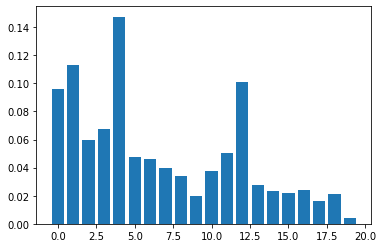

In [22]:
plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)
plt.show()

In [23]:
rf_feat = rf.feature_importances_

In [24]:
rf_mod = rf_feat.argsort()[-5:][::-1]

In [25]:
rf_mod

array([ 4,  1, 12,  0,  3], dtype=int64)

In [26]:
type(X_train)

numpy.ndarray

In [27]:
X_train = X_train[:, rf_mod]

In [28]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
X_test = X_test[:, rf_mod]

In [30]:
# Predicting the Test set results
y_pred = rf.predict(X_test)

In [31]:
rf_acc = accuracy_score(y_test, rf.predict(X_test))
print(accuracy_score(y_test, rf.predict(X_test)))

0.73


In [32]:
rf_auc = roc_auc_score(y_test, rf.predict(X_test))
print(roc_auc_score(y_test, rf.predict(X_test)))

0.6364740165128703


In [33]:
# Saving model using pickle
pickle.dump(rf, open('model.pkl','wb'))

In [34]:
# Loading model to compare the results
model = pickle.load(open('model.pkl','rb'))
# print(model.predict([[1.8]]))

In [35]:
fin = X_train_ori.iloc[:, rf_mod]

In [36]:
fin

,credit_amount,duration_in_month,age,account_check_status,purpose
687,2862,36,30,0 <= ... < 200 DM,car (new)
500,3123,24,27,< 0 DM,car (new)
332,7408,60,24,0 <= ... < 200 DM,car (new)
979,1264,15,25,0 <= ... < 200 DM,car (new)
817,1554,6,24,no checking account,domestic appliances
...,...,...,...,...,...
835,1082,12,48,< 0 DM,car (new)
192,3915,27,36,0 <= ... < 200 DM,business
629,3832,9,64,no checking account,(vacation - does not exist?)
559,1928,18,31,0 <= ... < 200 DM,radio/television


In [37]:
fin.dtypes

credit_amount            int64
duration_in_month        int64
age                      int64
account_check_status    object
purpose                 object
dtype: object

In [38]:
# Categorical boolean mask
categorical_feature_mask = fin.dtypes==object
numerical_feature_mask = fin.dtypes!=object

# filter categorical columns using mask and turn it into a list
categorical_cols = fin.columns[categorical_feature_mask]
numerical_cols = fin.columns[numerical_feature_mask]

In [39]:
temp = {}
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(X_train_ori[col])
    temp[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [40]:
temp

{'account_check_status': {'0 <= ... < 200 DM': 0,
  '< 0 DM': 1,
  '>= 200 DM / salary assignments for at least 1 year': 2,
  'no checking account': 3},
 'purpose': {'(vacation - does not exist?)': 0,
  'business': 1,
  'car (new)': 2,
  'car (used)': 3,
  'domestic appliances': 4,
  'education': 5,
  'furniture/equipment': 6,
  'radio/television': 7,
  'repairs': 8,
  'retraining': 9}}

In [42]:
X_train_ori['credit_amount'].describe()

count      800.000000
mean      3240.373750
std       2831.611332
min        250.000000
25%       1344.000000
50%       2281.500000
75%       3941.500000
max      18424.000000
Name: credit_amount, dtype: float64

In [45]:
X_train_ori['age'].describe()

count    800.000000
mean      35.907500
std       11.620036
min       19.000000
25%       27.000000
50%       33.500000
75%       42.000000
max       75.000000
Name: age, dtype: float64

In [46]:
X_train_ori['duration_in_month'].describe()

count    800.00000
mean      20.74375
std       12.05694
min        4.00000
25%       12.00000
50%       18.00000
75%       24.00000
max       72.00000
Name: duration_in_month, dtype: float64

In [4]:
with open('encode.json', 'w') as f:
    json.dump(temp, f)